In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import gzip
import os
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

2024-04-11 05:56:21.655663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 05:56:21.655764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 05:56:21.802835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_images_from_folder(folder):
    images = []
    labels = []
    label_map = {} 
    label_counter = 0

    for label in sorted(os.listdir(folder)):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            label_map[label] = label_counter
            for filename in os.listdir(label_folder):
                if filename.endswith('.jpg'):
                    image_path = os.path.join(label_folder, filename)
                    image = load_img(image_path, color_mode='rgb', target_size=(32, 32))
                    image_array = img_to_array(image)
                    images.append(image_array)
                    labels.append(label_counter)
            label_counter += 1

    return np.array(images), np.array(labels), label_map

train_path = "/kaggle/input/cifar-image-dataset/CIFAR-10-images-master/train"
test_path = "/kaggle/input/cifar-image-dataset/CIFAR-10-images-master/test"

train_images, train_labels, label_map = load_images_from_folder(train_path)
test_images, test_labels, _ = load_images_from_folder(test_path)

In [3]:
print("Number of train images:", len(train_images))
print("Number of train labels:", len(train_labels))
print("Number of test images:", len(test_images))
print("Number of test labels:", len(test_labels))

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test labels: 10000


In [4]:
train_images=train_images/255.0
test_images=test_images/255.0

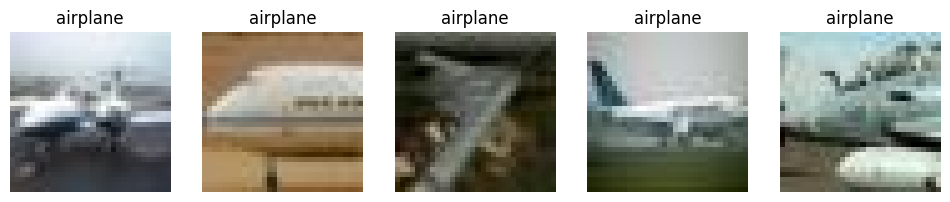

In [5]:
def plot_images(images, labels, label_map, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(list(label_map.keys())[list(label_map.values()).index(labels[i])])
        ax.axis('off')
    plt.show()
    
plot_images(train_images, train_labels, label_map)


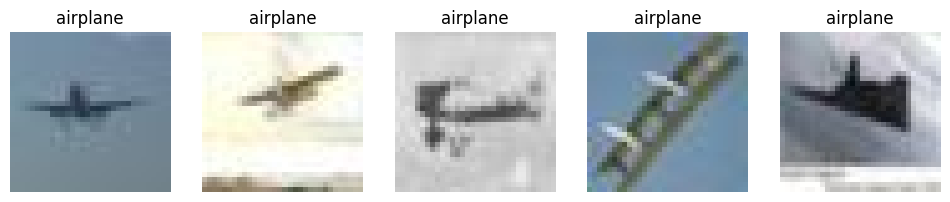

In [6]:
plot_images(test_images, test_labels, label_map)

In [7]:

print("Shape of training images:", train_images.shape)
print("Shape of testing images:", test_images.shape) 
print("Shape of testing labels:", test_labels.shape)
print("Shape of training labels:", train_labels.shape)

Shape of training images: (50000, 32, 32, 3)
Shape of testing images: (10000, 32, 32, 3)
Shape of testing labels: (10000,)
Shape of training labels: (50000,)


In [8]:

from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

val_images = val_images / 255.0

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Add

def residual_block(x, filters, downsample=False):
    strides = 1
    if downsample:
        strides = 2
        x = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    y = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size=3, strides=1, padding='same')(y)
    y = BatchNormalization()(y)
    if downsample:
        x = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    out = tf.keras.layers.add([x, y])
    out = Activation('relu')(out)
    return out

inputs = Input(shape=(32, 32, 3))
x = Conv2D(64, 7, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(3, strides=2, padding='same')(x)

num_blocks_list = [2, 2, 2, 2]
for i, num_blocks in enumerate(num_blocks_list):
    for j in range(num_blocks):
        downsample = False
        if j == 0 and i != 0:
            downsample = True
        x = residual_block(x, 64 * (2 ** i), downsample)

x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary() 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 64)  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ max_pooling2d[0]… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 8, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 8, 64)  │          0 │ activation_2[0][… │
│                     │                   │            │ batch_normalizat

 Total params: 13,085,706 (49.92 MB)

 Trainable params: 13,077,898 (49.89 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=50, validation_data=(val_images, val_labels))

Epoch 1/50
   7/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.1065 - loss: 4.1564 

I0000 00:00:1712815528.516447      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.3408 - loss: 1.9839 - val_accuracy: 0.0985 - val_loss: 3.2125
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5273 - loss: 1.3468 - val_accuracy: 0.0986 - val_loss: 2.9925
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.6020 - loss: 1.1494 - val_accuracy: 0.1008 - val_loss: 3.1248
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6547 - loss: 1.0122 - val_accuracy: 0.0985 - val_loss: 3.1773
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6781 - loss: 0.9402 - val_accuracy: 0.0986 - val_loss: 3.1961
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7111 - loss: 0.8435 - val_accuracy: 0.1008 - val_loss: 3.2773
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7340 - loss: 0.7841 - val_accuracy: 0.0985 - val_loss: 2.9854
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7550 - loss: 0.72

In [11]:

test_loss, test_accuracy = model.evaluate(test_images,test_labels)
print("Test Accuracy:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6827 - loss: 1.9682
Test Accuracy: 0.7109000086784363


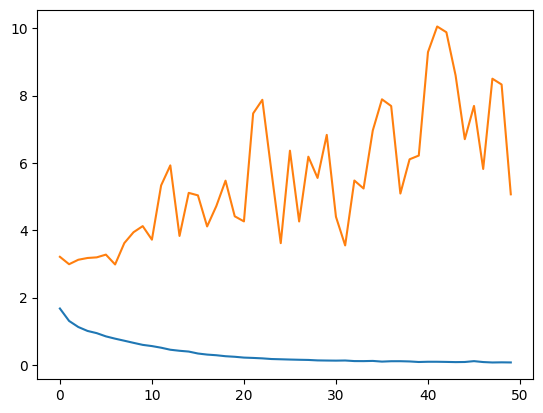

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

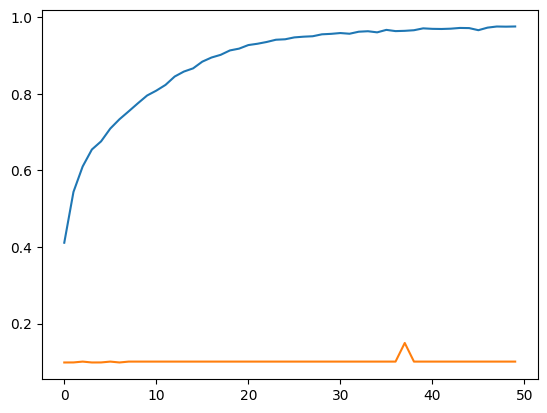

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


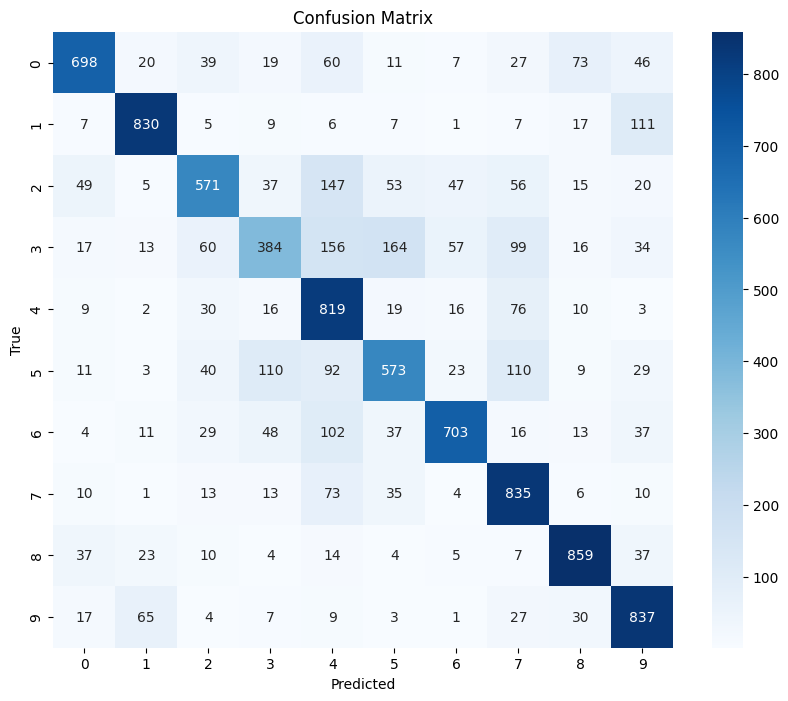

In [14]:
y_pred = np.argmax(model.predict(test_images), axis=-1)
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:

probabilities = model.predict(test_images)

predicted_classes = np.argmax(probabilities, axis=-1)
predicted_classes

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([0, 2, 0, ..., 1, 7, 9])

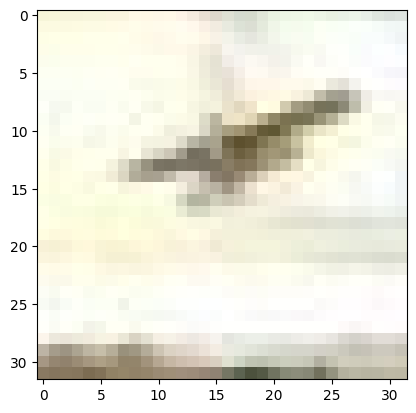

In [16]:
plt.imshow(test_images[1])